# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Data loading](#Data-loading)
* [Setup](#Setup)
* [Select FRILL columns](#Select-FRILL-columns)
* [Linear discriminant analysis of FRILL embeddings](#Linear-discriminant-analysis-of-FRILL-embeddings)
* [One-class SVM scores of the LDA components of the FRILL embeddings](One-class-SVM-scores-of-the-LDA-components-of-the-FRILL-embeddings)
* [SGDOneClassSVM scores of FRILL embeddings](#SGDOneClassSVM-scores-of-FRILL-embeddings-and-resultant-LDA-components)
* [Robust scaling](#Aggregate-and-scale)
* [Spot check](#Spot-check)
* [Discussion](#Discussion)

# Introduction

Three holdout datasets have been identified. This notebook featurizes them.

# Imports and configuration

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2022)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd

# utility
from copy import deepcopy
from joblib import load as joblib_load
from gc import collect as gc_collect
from tqdm.notebook import tqdm

# faster
import swifter
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# other sklearn
from sklearn.linear_model import SGDOneClassSVM
from sklearn.svm import OneClassSVM

# typing
from typing import Callable, List

# visualization
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# %matplotlib widget
sns.set_theme(context="notebook", style="ticks", palette="colorblind")

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 3.87 s


In [4]:
# Location of exported feature extractors
FEATURE_EXTRACTORS = "./feature_extractors"

# Location of holdout labels and FRILL columns
HOLDOUT = "../21.0-mic-prepare_holdout_datasets_for_evaluation"

# Location where this notebook will output
OUT_FOLDER = "."

_ = gc_collect()

time: 171 ms


# Setup

In [5]:
# valence label codes
VALENCE = {"neg": 0, "neu": 1, "pos": 2}
VALENCES = ("neg", "neu", "pos")
NEIGHBORS = (10, 20, 30)
OC_SVM = ("sgdlinear", "rbf")

feature_trio = lambda prefix, suffix: [
    f"{f'{prefix}_' if prefix else ''}{valence}{f'_{suffix}' if suffix else ''}"
    for valence in VALENCES
]

load_extractor = lambda feature_file: joblib_load(
    f"{FEATURE_EXTRACTORS}/{feature_file}.joblib"
)


def spot_check(
    data: pd.DataFrame, labels: pd.DataFrame, expected_columns: List[str] = []
) -> None:
    """Spot check feature extraction process"""
    assert all(data.index == labels.index)
    assert not data.isnull().values.any()
    if expected_columns:
        assert list(data.columns) == expected_columns
    print(data.info())
    print(data.head())


_ = gc_collect()

time: 143 ms


In [6]:
def plot1d(data: pd.DataFrame, labels: pd.DataFrame, x: str) -> None:
    sns.displot(
        x=data[x],
        hue=labels.valence,
        palette="viridis",
        linewidth=0,
        alpha=0.75,
        legend=False,
    )
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()


_ = -gc_collect()

time: 158 ms


In [7]:
def plot2d(data: pd.DataFrame, labels: pd.DataFrame, x: str, y: str) -> None:
    """Scatterplot of two variables"""
    _ = sns.histplot(
        x=data[x],
        y=data[y],
        cmap="RdPu",
        linewidth=0,
        alpha=0.2,
        legend=False,
        kde=True,
    )
    _ = sns.scatterplot(
        x=data[x],
        y=data[y],
        hue=labels.valence,
        palette="viridis",
        linewidth=0,
        alpha=0.75,
        legend=False,
        s=10,
    )
    sns.despine(**dict.fromkeys("top right left bottom".split(), True))
    plt.show()


_ = gc_collect()

time: 147 ms


In [8]:
def plot3d(data: pd.DataFrame, labels: pd.DataFrame, x: str, y: str, z: str) -> None:
    """Scatterplot of three variables"""
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(
        data[x],
        data[y],
        data[z],
        alpha=0.5,
        linewidth=0,
        cmap="viridis",
        c=labels.valence,
    )
    ax.grid(False)
    plt.show()


_ = gc_collect()

time: 157 ms


In [9]:
def checkpoint_features(df: pd.DataFrame, features: List[str]) -> None:
    """Save features to disk as a .feather dataframe"""
    df = df.loc[:, features]
    df.columns = df.columns.astype(str)
    try:
        df.to_feather(
            _ := f"{OUT_FOLDER}/holdout_{'_-_'.join(features) if len(features) > 1 else features[0]}.feather"
        )
    except ValueError:
        df.reset_index().to_feather(_)


_ = gc_collect()

time: 102 ms


# Load data

In [10]:
frill = pd.read_feather(f"{HOLDOUT}/holdout_FRILL.feather")
labels = pd.read_feather(f"{HOLDOUT}/holdout_labels.feather").drop(columns="id")
spot_check(frill, labels)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1957 entries, 0 to 1956
Columns: 2048 entries, 0 to 2047
dtypes: float32(2048)
memory usage: 15.3 MB
None
          0         1         2         3         4         5         6  \
0 -0.035624  0.148898 -0.109508 -0.016199 -0.084427 -0.067872  0.174007   
1 -0.103035  0.082011  0.110948 -0.060209 -0.073397  0.009772 -0.020830   
2 -0.065101  0.038458 -0.029423  0.005429 -0.023002  0.152135  0.053979   
3  0.083481  0.138969 -0.030347  0.062699  0.073357 -0.039354 -0.089715   
4  0.019141  0.170539 -0.056348  0.032532 -0.089482  0.079703  0.037175   

          7         8         9  ...      2038      2039      2040      2041  \
0 -0.033383 -0.017896 -0.024012  ... -0.153698  0.041551 -0.003445 -0.059062   
1  0.044276  0.046892 -0.115516  ...  0.065289  0.075569 -0.089013 -0.161597   
2 -0.039011  0.017791 -0.077413  ... -0.042246 -0.004320 -0.040200 -0.049798   
3  0.113456  0.039636 -0.041954  ...  0.022920 -0.181787  0.011134 -0.073

In [11]:
labels.reset_index(drop=True).to_feather(f"{OUT_FOLDER}/holdout_labels.feather")

time: 26 ms


# Select FRILL columns

In [12]:
# selector = load_extractor("frill_column_selector")
# selected_frill_columns = selector.get_feature_names_out(frill.columns)
with open(
    "../23.0-mic-train_new_prototypes_with_simplified_pipeline/selected_frill_columns.txt",
    "r",
) as f:
    selected_frill_columns = f.readlines()
selected_frill_columns = [line.strip() for line in selected_frill_columns]
# frill = pd.DataFrame(selector.transform(frill), columns=selected_frill_columns)
frill = frill.loc[:, selected_frill_columns]
spot_check(frill, labels)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1957 entries, 0 to 1956
Columns: 1024 entries, 0 to 2047
dtypes: float32(1024)
memory usage: 7.6 MB
None
          0         7        15        16        18        20        21  \
0 -0.035624 -0.033383  0.043033 -0.041507  0.226673  0.008828  0.176655   
1 -0.103035  0.044276  0.059442 -0.119909  0.345795  0.045072  0.067420   
2 -0.065101 -0.039011  0.028183 -0.048056  0.059421 -0.064515  0.084881   
3  0.083481  0.113456  0.039784 -0.049637  0.207155  0.128711  0.013286   
4  0.019141  0.046567  0.015699 -0.064816  0.255913  0.091518  0.044819   

         22        30        32  ...      2023      2024      2026      2028  \
0 -0.029301  0.070888  0.012144  ...  0.040793  0.047765 -0.024035 -0.051325   
1  0.050928 -0.068873  0.043356  ...  0.049300 -0.069195  0.022934  0.004956   
2 -0.066782  0.055454 -0.004342  ... -0.026597 -0.028739  0.078741  0.086177   
3  0.136444  0.035383 -0.020022  ... -0.000103  0.099276  0.011584 -0.0393

# Linear discriminant analysis components of FRILL embeddings

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1957 entries, 0 to 1956
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   LDA1    1957 non-null   float64
 1   LDA2    1957 non-null   float64
dtypes: float64(2)
memory usage: 30.7 KB
None
       LDA1      LDA2
0 -1.506022  0.724455
1 -2.012732  0.636784
2 -1.592665  1.856882
3 -0.224248  2.123781
4 -1.645159  1.678552


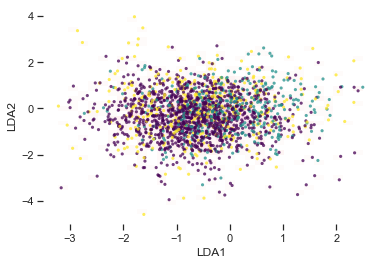

time: 713 ms


In [13]:
features = ["LDA1", "LDA2"]
data = pd.DataFrame(load_extractor("LDA1_-_LDA2").transform(frill), columns=features)
spot_check(data, labels)
plot2d(data, labels, *features)
checkpoint_features(data, features)

# Local outlier factor of LDA components of FRILL embeddings

  0%|          | 0/3 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1957 entries, 0 to 1956
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   LDA1            1957 non-null   float64
 1   LDA2            1957 non-null   float64
 2   LDA-LOF_neg_20  1957 non-null   float64
 3   LDA-LOF_neu_20  1957 non-null   float64
 4   LDA-LOF_pos_20  1957 non-null   float64
dtypes: float64(5)
memory usage: 76.6 KB
None
       LDA1      LDA2  LDA-LOF_neg_20  LDA-LOF_neu_20  LDA-LOF_pos_20
0 -1.506022  0.724455       -1.007432       -1.303784       -1.024339
1 -2.012732  0.636784       -1.032912       -1.466157       -1.028627
2 -1.592665  1.856882       -1.024155       -1.156847       -1.042566
3 -0.224248  2.123781       -1.023477       -1.029984       -1.056383
4 -1.645159  1.678552       -1.136594       -1.149785       -0.986925


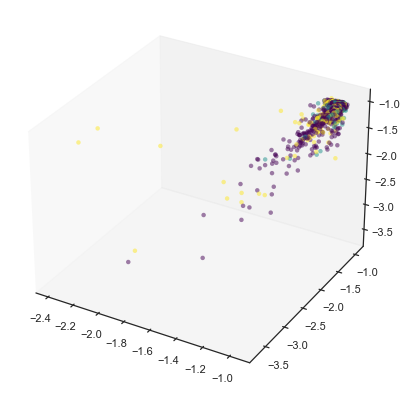

time: 889 ms


In [14]:
n_neighbors = 20
features = []
for valence in tqdm(VALENCES):
    feature = f"LDA-LOF_{valence}_{n_neighbors}"
    data[feature] = load_extractor(feature).score_samples(data.loc[:, ["LDA1", "LDA2"]])
    features.append(feature)
    del feature
    _ = gc_collect()

spot_check(data, labels)
plot3d(data, labels, *features)
checkpoint_features(data, features)

# One-class SVM scores of the LDA components of the FRILL embeddings

In [15]:
def extract_ocsvm_features(
    df: pd.DataFrame, labels: pd.DataFrame, descriptor: str
) -> pd.DataFrame:
    """Extract features using the given one-class SVM base"""
    prefix = f"ocSVM_{descriptor}"
    assert all(df.index == labels.index)

    # one-class scores of LDA components of FRILL embeddings
    print("extracting one-class scores of LDA components of FRILL embeddings...")
    for valence in VALENCE.keys():
        feature = f"LDA-{prefix}_{valence}"
        df[feature] = load_extractor(feature).score_samples(df.loc[:, ["LDA1", "LDA2"]])
        del feature
        _ = gc_collect()
    assert all(df.index == labels.index)
    features = [f"LDA-{prefix}_neg", f"LDA-{prefix}_neu", f"LDA-{prefix}_pos"]
    plot3d(df, labels, *features)
    checkpoint_features(df, features)

    return df


_ = gc_collect()

time: 109 ms


  0%|          | 0/2 [00:00<?, ?it/s]

extracting one-class scores of LDA components of FRILL embeddings...


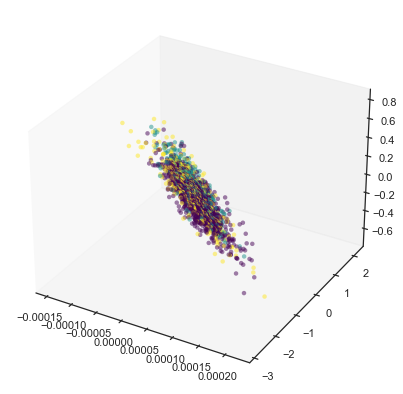

extracting one-class scores of LDA components of FRILL embeddings...


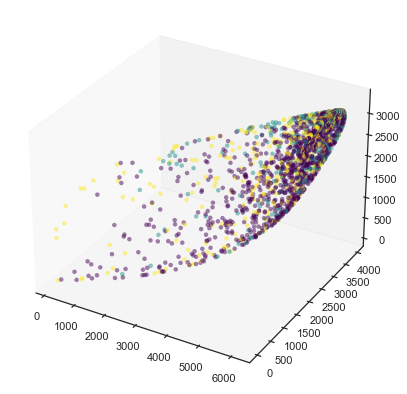

time: 13.7 s


In [16]:
for oc_svm in tqdm(OC_SVM):
    data = extract_ocsvm_features(data, labels, oc_svm)

# SGDOneClassSVM scores of FRILL embeddings

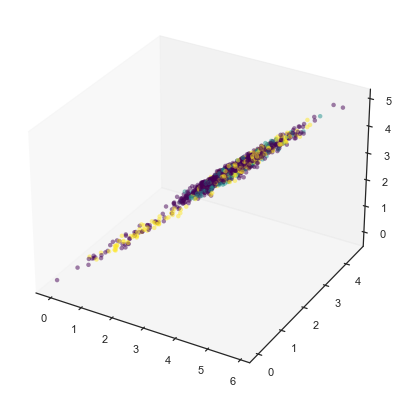

time: 687 ms


In [17]:
prefix = f"ocSVM_sgdlinear"
for valence in VALENCE.keys():
    feature = f"{prefix}_{valence}"
    data[feature] = load_extractor(feature).score_samples(frill)
    _ = gc_collect()
features = [f"{prefix}_neg", f"{prefix}_neu", f"{prefix}_pos"]
plot3d(data, labels, *features)
checkpoint_features(data, features)

# Robust scaling

In [18]:
scaler = load_extractor("robust_scaler")
data = pd.DataFrame(scaler.transform(data), columns=scaler.feature_names_in_)
del scaler
_ = gc_collect()
spot_check(data, labels)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1957 entries, 0 to 1956
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   LDA1                     1957 non-null   float64
 1   LDA2                     1957 non-null   float64
 2   ocSVM_sgdlinear_neg      1957 non-null   float64
 3   ocSVM_sgdlinear_neu      1957 non-null   float64
 4   ocSVM_sgdlinear_pos      1957 non-null   float64
 5   LDA-LOF_neg_20           1957 non-null   float64
 6   LDA-LOF_neu_20           1957 non-null   float64
 7   LDA-LOF_pos_20           1957 non-null   float64
 8   LDA-ocSVM_rbf_neg        1957 non-null   float64
 9   LDA-ocSVM_rbf_neu        1957 non-null   float64
 10  LDA-ocSVM_rbf_pos        1957 non-null   float64
 11  LDA-ocSVM_sgdlinear_neg  1957 non-null   float64
 12  LDA-ocSVM_sgdlinear_neu  1957 non-null   float64
 13  LDA-ocSVM_sgdlinear_pos  1957 non-null   float64
dtypes: float64(14)
memory us

In [19]:
data.columns = data.columns.astype(str)
data.to_feather(f"{OUT_FOLDER}/holdout_featurized.feather")
data = pd.read_feather(f"{OUT_FOLDER}/holdout_featurized.feather")
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1957 entries, 0 to 1956
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   LDA1                     1957 non-null   float64
 1   LDA2                     1957 non-null   float64
 2   ocSVM_sgdlinear_neg      1957 non-null   float64
 3   ocSVM_sgdlinear_neu      1957 non-null   float64
 4   ocSVM_sgdlinear_pos      1957 non-null   float64
 5   LDA-LOF_neg_20           1957 non-null   float64
 6   LDA-LOF_neu_20           1957 non-null   float64
 7   LDA-LOF_pos_20           1957 non-null   float64
 8   LDA-ocSVM_rbf_neg        1957 non-null   float64
 9   LDA-ocSVM_rbf_neu        1957 non-null   float64
 10  LDA-ocSVM_rbf_pos        1957 non-null   float64
 11  LDA-ocSVM_sgdlinear_neg  1957 non-null   float64
 12  LDA-ocSVM_sgdlinear_neu  1957 non-null   float64
 13  LDA-ocSVM_sgdlinear_pos  1957 non-null   float64
dtypes: float64(14)
memory us

,LDA1,LDA2,ocSVM_sgdlinear_neg,ocSVM_sgdlinear_neu,ocSVM_sgdlinear_pos,LDA-LOF_neg_20,LDA-LOF_neu_20,LDA-LOF_pos_20,LDA-ocSVM_rbf_neg,LDA-ocSVM_rbf_neu,LDA-ocSVM_rbf_pos,LDA-ocSVM_sgdlinear_neg,LDA-ocSVM_sgdlinear_neu,LDA-ocSVM_sgdlinear_pos
0,-1.093794,0.716794,-3.704280,-5.271451,-4.017338,37.349719,-3.585270,34.379693,-0.198683,-1.242441,0.431666,60255.001735,2.389527,16.356833
1,-1.495297,0.634760,-3.725226,-5.484168,-4.021554,37.350431,-11.236630,35.412674,-0.919008,-1.707265,-0.110810,58331.383745,2.360206,15.585649
2,-1.162448,1.776413,-3.718027,-5.078957,-4.035256,37.348390,-3.794420,39.195493,-2.235714,-1.723605,0.308069,64258.705720,2.658909,17.368520
3,-0.078153,2.026152,-3.717469,-4.912761,-4.048839,37.346427,16.897655,36.527675,-2.257487,-0.879280,0.241915,77901.221465,3.012599,20.371459
4,-1.204043,1.609548,-3.810456,-5.069706,-3.980558,37.348678,-4.749219,38.618218,-1.929033,-1.690760,0.311885,68153.313952,2.592953,18.465873


time: 46.9 ms


In [20]:
training_data = (
    pd.read_feather(f"./scaled_features_ready_for_selection.feather")
    .set_index("id")
    .head(1)
)

assert set(data.columns) - set(training_data.columns) == set()
assert len(data.columns) == len(training_data.columns)
assert set(data.columns) == set(training_data.columns)
_ = gc_collect()

time: 141 ms


# Discussion

Now that we have the features, let's evaluate them in the next notebook. The visualizations don't look so clean, so let's hope for the best.|

In [21]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 27.639071702957153 s
time: 109 ms


[^top](#Contents)